In [ ]:
!pip install torchdyn torchdiffeq wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 619.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

Генерируем данные маятника.

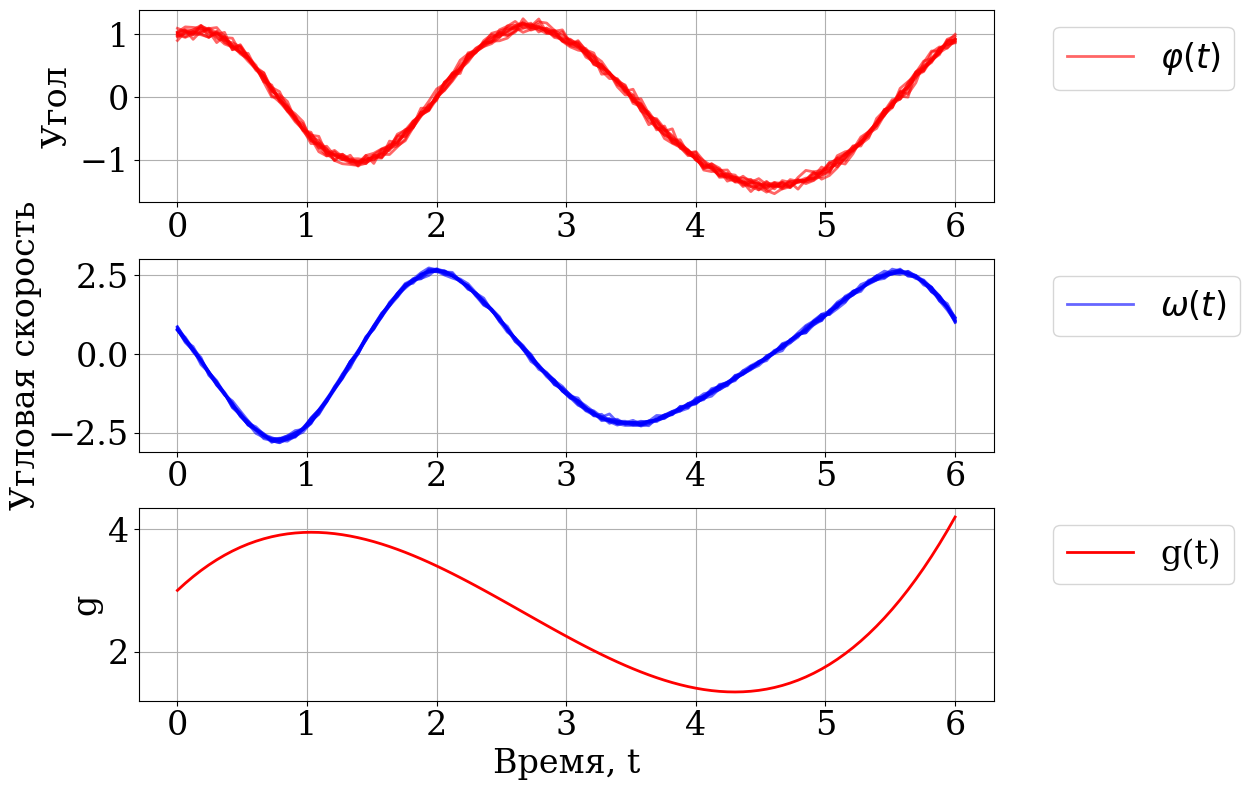

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchdiffeq import odeint_adjoint as odeint
from torch.utils.data import DataLoader, TensorDataset
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

def solve_pendulum(g, L, initial_conditions, t_span, t_eval=None, method='RK45', rtol=1e-6):
    def pendulum_ode(t, y):
        phi, omega = y
        current_g = g(t)
        return [omega, -(current_g / L) * np.sin(phi)]

    sol = solve_ivp(pendulum_ode, t_span, initial_conditions, t_eval=t_eval, method=method, rtol=rtol)
    return sol

def generate_trajectories(num_trajectories, g, L, initial_conditions, vars, t_span, t_eval=None, method='RK45', rtol=1e-6):
  trajectories = []
  for _ in range(num_trajectories):
      sol_i = solve_pendulum(g, L, initial_conditions, t_span, t_eval)
      phi = sol_i.y[0] + np.random.normal(0, vars[0], sol_i.y[0].shape)
      omega = sol_i.y[1] + np.random.normal(0, vars[1], sol_i.y[1].shape)
      trajectories.append({
          'x0': np.array([*initial_conditions, g(t_span[0])]),
          'true_z': np.vstack([phi, omega]).T
      })
  return trajectories


a = 0.15    # Сильная кубическая нелинейность
b = -1.2    # Резкий "горб" в середине интервала
c = 2.0     # Быстрый линейный рост
d = 3.0     # Низкое стартовое значение (увеличивает чувствительность)
g = lambda t: a * t**3 + b * t**2 + c * t + d
vars = [0.05, 0.05]
phi0 = 1
omega0 = np.pi / 4
t_span = [0, 6]
t_eval = np.linspace(*t_span, 100)
L = 0.5
num_trajectories = 10

trajectories = generate_trajectories(num_trajectories, g, L, [phi0, omega0], vars, t_span, t_eval)

true_z = torch.stack([torch.tensor(traj['true_z'], dtype=torch.float32) for traj in trajectories])
x0 = torch.tensor([phi0, omega0, d]).repeat((num_trajectories, 1))
dataset = TensorDataset(x0, true_z)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))

for i in range(num_trajectories):
  if i == 0:
    ax1.plot(t_eval, true_z[i, :, 0], label=r'$\varphi(t)$', color='red', alpha=0.6)
  else:
    ax1.plot(t_eval, true_z[i, :, 0], color='red', alpha=0.6)
ax1.set_ylabel('Угол')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

for i in range(num_trajectories):
  if i == 0:
    ax2.plot(t_eval, true_z[i, :, 1], label=r'$\omega(t)$', color='blue', alpha=0.6)
  else:
    ax2.plot(t_eval, true_z[i, :, 1], color='blue', alpha=0.6)
ax2.set_ylabel('Угловая скорость')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

ax3.plot(t_eval, g(t_eval), 'r-', label='g(t)')
ax3.set_xlabel('Время, t')
ax3.set_ylabel('g')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [ ]:
class F(nn.Module):
    def __init__(self, L=0.5):
        super().__init__()
        self.L = L

    def forward(self, t, x):
        theta, omega, g = x[:, 0], x[:, 1], x[:, 2]
        theta_dot = omega
        omega_dot = -(g / self.L) * torch.sin(theta)
        return torch.stack([theta_dot, omega_dot], dim=1)

class GPolyPrime(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1) * 0.1)
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1))

    def forward(self, t):
        return 3*self.a * t**2 + 2*self.b * t + self.c

class ODEFunc(nn.Module):
    def __init__(self, f, g_prime):
        super().__init__()
        self.f = f
        self.g_prime = g_prime

    def forward(self, t, state):
        z = state[:, :2]
        g = state[:, 2:]
        t_tensor = t * torch.ones(state.size(0), 1, device=state.device)
        g_prime = self.g_prime(t_tensor)
        dz = self.f(t, torch.cat([z, g], dim=1))
        dg = g_prime
        return torch.cat([dz, dg], dim=1)

In [ ]:
device

device(type='cuda')

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import TQDMProgressBar

class ODELightningModule(pl.LightningModule):
    def __init__(self, ode_func, t, lr=0.001):
        super().__init__()
        self.ode_func = ode_func
        self.lr = lr
        self.criterion = nn.MSELoss()
        self.register_buffer("t", t)

    def forward(self, x0):
        return odeint(self.ode_func, x0, self.t, rtol=1e-6, atol=1e-6)

    def training_step(self, batch, batch_idx):
        x0_batch, true_z_batch = batch
        pred_traj = self.forward(x0_batch)
        pred_z = pred_traj[:, :, :2].permute(1, 0, 2)
        loss = self.criterion(pred_z, true_z_batch)
        print(loss)

        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True, logger=False)
        # self.log("epoch_train_loss", loss, prog_bar=False, on_step=False, on_epoch=True, logger=True)
        return {"loss": loss}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=5,
                verbose=True
            ),
            'monitor': 'train_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return optimizer

t = torch.tensor(t_eval, dtype=torch.float32).to(device)
f = F(L=L).to(device)
g_prime_poly = GPolyPrime().to(device)
ode_func = ODEFunc(f, g_prime_poly).to(device)
model = ODELightningModule(ode_func, t, lr=0.05)

wandb_logger = WandbLogger(project="pendulum_ode")
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=True, logger=wandb_logger, callbacks=[TQDMProgressBar(refresh_rate=1)], log_every_n_steps=1)
trainer.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory ./pendulum_ode/y5b2is2l/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Training: |          | 0/? [00:00<?, ?it/s]

tensor(3.7117, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.4612, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7038, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.6116, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.2383, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1760, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.6475, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.4887, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.0710, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1898, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.4341, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.3120, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.0933, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.0748, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.2746, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.2377, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.0444, device='cuda:0', grad_fn=

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


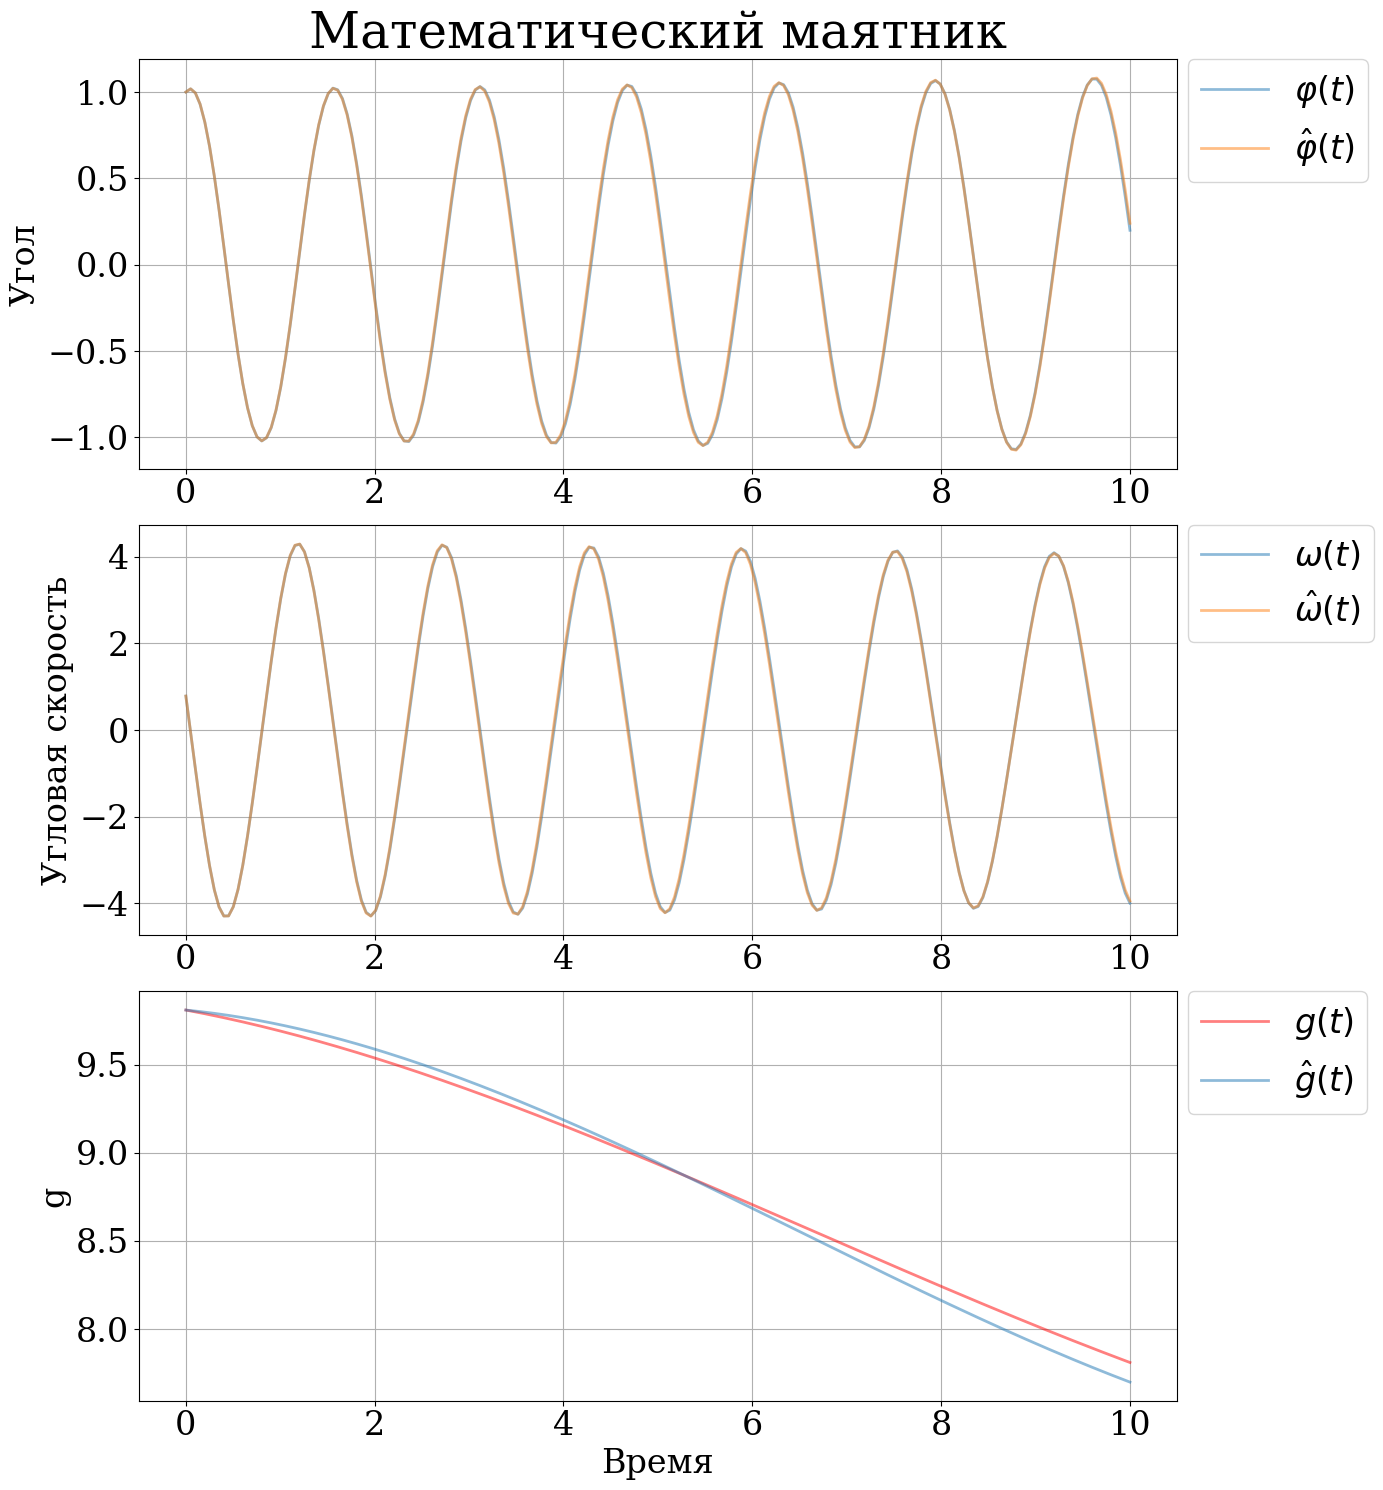

In [ ]:
# plt.plot(t.detach().cpu(), model.forward()[:, :, 0].squeeze().detach().cpu(), label='not target')
# plt.plot(t.detach().cpu(), sol.y[0], label='target')
# plt.legend()
# plt.show()

# plt.plot(t.detach().cpu(), model.forward()[:, :, 1].squeeze().detach().cpu(), label='not target')
# plt.plot(t.detach().cpu(), sol.y[1], label='target')
# plt.legend()
# plt.show()

# plt.plot(t.detach().cpu(), model.forward()[:, :, 2].squeeze().detach().cpu(), label='target')
# plt.plot(t.detach().cpu(), g(t.detach().cpu()), label=r'$\varphi(t)$')
# plt.legend()
# plt.show()

alpha = 0.5
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Первый график
ax1.plot(sol.t, sol.y[0], label=r'$\varphi(t)$', alpha=alpha)
ax1.plot(t.detach().cpu(), model.forward()[:, :, 0].squeeze().detach().cpu(), label=r'$\hat\varphi(t)$', alpha=alpha)
ax1.set_ylabel('Угол')
ax1.set_title('Математический маятник')
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
ax1.grid(True)

# Второй график
ax2.plot(sol.t, sol.y[1], label=r'$\omega(t)$', alpha=alpha)
ax2.plot(t.detach().cpu(), model.forward()[:, :, 1].squeeze().detach().cpu(), label=r'$\hat\omega(t)$', alpha=alpha)
ax2.set_ylabel('Угловая скорость')
ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
ax2.grid(True)

# Третий график
ax3.plot(sol.t, g(sol.t), 'r-', label=r'$g(t)$', alpha=alpha)
ax3.plot(t.detach().cpu(), model.forward()[:, :, 2].squeeze().detach().cpu(), label=r'$\hat g(t)$', alpha=alpha)
ax3.set_xlabel('Время')
ax3.set_ylabel('g')
ax3.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
ax3.grid(True)

plt.tight_layout(rect=[0, 0, 0.93, 1])  # Уменьшил правый отступ с 0.85 до 0.93
plt.savefig('plot.png')
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))

ax1.plot(sol.t, sol.y[0], label=r'$\varphi(t)$')
ax1.set_ylabel('Угол')
ax1.set_title('Математический маятник')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

ax2.plot(sol.t, sol.y[1], label=r'$\omega(t)$')
ax2.set_ylabel('Угловая скорость')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

ax3.plot(sol.t, g(sol.t), 'r-', label='g(t)')
ax3.set_xlabel('Время')
ax3.set_ylabel('g')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()